# Predicting sentiment from product reviews

As usual the most basic imports are on top.

In this project, we are using data from Amazon, babies products reviews to be specific. 
We are trying to identify positive and negative reviews based on rating and sentiment written by customers.

Solutions like this in machine learning and statistics are called **classification**.

Well then, what is classification? 

*A classification model attempts to draw some conclusion from observed values. Given one or more inputs a classification model will try to predict the value of one or more outcomes. Outcomes are labels that can be applied to a dataset. For example, when filtering emails “spam” or “not spam” , when looking at transaction data, “fraudulent”, or “authorized”*

In [36]:
import json
import math
import operator
import string
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import Imputer

### Loading reviews for a set of baby products.

Firsly, let's read required data from CSV file. In this project we will be working on data from Amazon, and to be more specific, we will be manipulating data about things for babies.

In [37]:
data = pd.read_csv('../lectures/data/amazon_baby.csv')

Let's review some data to check how it looks like.

In [38]:
data.head()

,name,review,rating
0,Planetwise Flannel Wipes,"These flannel wipes are OK, but in my opinion ...",3
1,Planetwise Wipe Pouch,it came early and was not disappointed. i love...,5
2,Annas Dream Full Quilt with 2 Shams,Very soft and comfortable and warmer than it l...,5
3,Stop Pacifier Sucking without tears with Thumb...,This is a product well worth the purchase. I ...,5
4,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5


As we can see, we have four columns: index, name of a object, review of it and rating. 
In this task we will try to classify and analyze those reviews to find out the best and the worst items.

### Data cleaning

Let's see how the single entry looks like.

In [39]:
data['review'][0]

'These flannel wipes are OK, but in my opinion not worth keeping.  I also ordered someImse Vimse Cloth Wipes-Ocean Blue-12 countwhich are larger, had a nicer, softer texture and just seemed higher quality.  I use cloth wipes for hands and faces and have been usingThirsties 6 Pack Fab Wipes, Boyfor about 8 months now and need to replace them because they are starting to get rough and have had stink issues for a while that stripping no longer handles.'

Text contains punctuations which we don't need, so we should remove them:

In [40]:
data['review_clean'] = data['review'].str.replace('[^\w\s]', '')

Look at reviews 30 to 50, we see some bad data for review

In [41]:
data['review'][30:50]

30    Beautiful little book.  A great little short s...
31    This book is so worth the money. It says 9+ mo...
32    we just got this book for our one-year-old and...
33    The book is colorful and is perfect for 6month...
34    The book is cute, and we are huge fans of Lama...
35    What a great book for babies!  I'd been lookin...
36    My son loved this book as an infant.  It was p...
37    Our baby loves this book & has loved it for a ...
38                                                  NaN
39    My son likes brushing elmo's teeth. Almost too...
40    This was a birthday present for my 2 year old ...
41    This bear is absolutely adorable and I would g...
42    My baby absolutely loves Elmo and so this book...
43    I bought two for recent baby showers!  The boo...
44    We wanted to get another book like the Big Bir...
45    This is a cute little peek-a-boo story book.  ...
46    My 3 month old son loves this book. We read it...
47    Very cute interactive book! My son loves t

So let's clean that up

In [42]:
def cleanNaN(value):
    if pd.isnull(value):
        return ""
    else:
        return value

In [43]:
data['review_clean'] = data['review_clean'].apply(cleanNaN)

We removed punctuations and empty reviews. Let's review, how data looks after cleanup:

In [44]:
data['review_clean'][30:50]

30    Beautiful little book  A great little short st...
31    This book is so worth the money It says 9 mont...
32    we just got this book for our oneyearold and s...
33    The book is colorful and is perfect for 6month...
34    The book is cute and we are huge fans of Lamaz...
35    What a great book for babies  Id been looking ...
36    My son loved this book as an infant  It was pe...
37    Our baby loves this book  has loved it for a w...
38                                                     
39    My son likes brushing elmos teeth Almost too n...
40    This was a birthday present for my 2 year old ...
41    This bear is absolutely adorable and I would g...
42    My baby absolutely loves Elmo and so this book...
43    I bought two for recent baby showers  The book...
44    We wanted to get another book like the Big Bir...
45    This is a cute little peekaboo story book  Its...
46    My 3 month old son loves this book We read it ...
47    Very cute interactive book My son loves th

Now the data looks cleaner. We no longer have the NaN for the 38th review.

## Define what's a positive and a negative sentiment

We will ignore all reviews with rating = 3, since they tend to have a neutral sentiment.  Reviews with a rating of 4 or higher will be considered positive, while the ones with rating of 2 or lower will have a negative sentiment.

In [45]:
data = data[data.rating != 3]  # Ignore neutral ratings

data['sentiment'] = data['rating'].apply(lambda rating: +1 if rating > 3 else -1)  # Assign sentiment tags

After removing neutral reviews, we stayed with rates **1,2,4,5**, first two are negative sentiments, and the last two - positive. We will mark it in our data frame as a new column, called 'sentiment'.

Let's check how the data looks like now.

In [46]:
data.head()

,name,review,rating,review_clean,sentiment
1,Planetwise Wipe Pouch,it came early and was not disappointed. i love...,5,it came early and was not disappointed i love ...,1
2,Annas Dream Full Quilt with 2 Shams,Very soft and comfortable and warmer than it l...,5,Very soft and comfortable and warmer than it l...,1
3,Stop Pacifier Sucking without tears with Thumb...,This is a product well worth the purchase. I ...,5,This is a product well worth the purchase I h...,1
4,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5,All of my kids have cried nonstop when I tried...,1
5,Stop Pacifier Sucking without tears with Thumb...,"When the Binky Fairy came to our house, we did...",5,When the Binky Fairy came to our house we didn...,1


Number of positive and negative sentiments:

In [47]:
data.sentiment.value_counts()

 1    140259
-1     26493
Name: sentiment, dtype: int64

## Build the word count vector for each review

We will now compute the word count for each word that appears in the reviews.
A vector consisting of word counts is often referred to as bag-of-word features.
Since most words occur in only a few reviews, word count vectors are sparse.
For this reason, scikit-learn and many other tools use sparse matrices to
store a collection of word count vectors.

Firstly, we have to create two data sets: training set and test set using built-in method from scilearn.

In [48]:
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

Then, we have to count occurencies of the words in each review and collect them into a row vector.

Finally, we create a sparse matrix, where each row is the word count vector for the corresponding review. We have to do it for both, test and train data sets.

In [49]:
vectorizer = CountVectorizer(token_pattern=r'\b\w+\b')
train_matrix = vectorizer.fit_transform(train_data['review_clean'])
test_matrix = vectorizer.transform(test_data['review_clean'])

In classification model, we will use **Logistic Regression** to calculate probabilites. 

This is a variation of linear regression, where a model is made to calculate some dependent variable, y, based on some independent variable, x. Then y = mx + b. The model looks for the coefficient m and the y-intercept b.

In [50]:
sentiment_model = LogisticRegression()
sentiment_model.fit(train_matrix, train_data['sentiment'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [51]:
dx = sentiment_model.__dict__
coefs = dx['coef_'][0]

Let's check what is the number of coefficients:

In [52]:
print("Number of co-efficients", len(coefs))

Number of co-efficients 121871


In [53]:
count = 0
for co in coefs:
    if co >= 0:
        count += 1

And we should review as well the number of non negative coefficients.

In [54]:
print("Number of non negative coeffs ", count)

Number of non negative coeffs  85814


In [55]:
sample_test_data = test_data[10:13]
print(sample_test_data)

                                                    name  \
80054  Simple Wishes Hands-Free Breastpump Bra, Pink,...   
44765  Moby Wrap UV SPF 50+ 100% Cotton Baby Carrier,...   
48173  The First Years American Red Cross Deluxe Nail...   

                                                  review  rating  \
80054  I like the idea but the problems:-awkward clos...       2   
44765  This is my 2nd Moby, just wanted another color...       5   
48173  This is the best nail clipper! Definitely reco...       5   

                                            review_clean  sentiment  
80054  I like the idea but the problemsawkward closin...         -1  
44765  This is my 2nd Moby just wanted another color ...          1  
48173  This is the best nail clipper Definitely recom...          1  


In [56]:
def probability(score):
    return (1 / (1 + numpy.exp(-score)))

sample_test_matrix = vectorizer.transform(sample_test_data['review_clean'])
scores = sentiment_model.decision_function(sample_test_matrix)
print(scores)
print(sentiment_model.predict(sample_test_matrix))

[ -0.54655151  17.03374564   4.88448576]
[-1  1  1]


In [57]:
test_set_scores = sentiment_model.decision_function(test_matrix)
names = test_data["name"]
name_predictions = dict(zip(names, test_set_scores))

In [58]:
sorted_reviews = sorted(name_predictions.items(), key=operator.itemgetter(1), reverse=True)

We have our classification model, now we can predict the best 20 reviews and 20 the worst.

In [59]:
most_positive_reviews = sorted_reviews[:20]
print(most_positive_reviews)

[('Zooper 2011 Waltz Standard Stroller, Flax Brown', 63.963700627352594), ('Bumbleride 2011 Flite Lightweight Compact Travel Stroller, Jet', 56.882627606103611), ('Infantino Wrap and Tie Baby Carrier, Black Blueberries', 48.062728748311194), ('Buttons Cloth Diaper Cover - One Size - 8 Color Options', 47.123190592730438), ('Chicco Cortina Keyfit 30 Travel System, Miro', 40.913854370819955), ('phil&amp;teds Smart Buggy Bassinet and Stroller Bundle, Black', 40.572816629945635), ('Thirsties Duo Diaper Snap, Mud, Size One (6-18 lbs)', 39.128469920060709), ('Kiddy City N Move Stroller, Walnut', 38.323828266619657), ('Kolcraft Contours Lite Stroller Plus with iPod DOK in Cosmic', 36.734438584138793), ('bumGenius One-Size Hook &amp; Loop Closure Cloth Diaper 4.0 - Blossom', 36.596545673727505), ('Mamas &amp; Papas 2014 Urbo2 Stroller - Black', 36.542725759087389), ('Dream On Me / Mia Moda  Atmosferra Stroller, Nero', 36.288019253908523), ('Phil &amp; Teds Navigator Buggy Golden Kiwi Free 2nd S

In [60]:
most_negative_reviews = sorted_reviews[-1:-22:-1]
print(most_negative_reviews)

[("Graco Pack 'n Play Playard - Dempsey", -45.631291685698336), ('Zooper Twist Escape Stroller, Summer Day', -41.100818882554201), ('Dream On Me Bassinet, Blue', -30.600691361753562), ('Adiri BPA Free Natural Nurser Ultimate Bottle Stage 1 White, Slow Flow (0-3 months)', -28.502264398284915), ("Evenflo Expressions Plus High Chair - 3's Company", -26.672716036785836), ('Peg-Perego Vela Easy Drive Stroller, Geranium', -24.640082440914369), ('Kidz Delight Smithsonian Kids Space Tablet', -21.192190469893958), ('Summer Infant Connect Internet Camera System', -20.587741615436805), ('Chicco Cortina Stroller - Iceberg', -20.30762295874041), ('Newborn Baby Pea in The Pod Halloween Costume, 0-6 Months', -19.886354150268517), ('Moonrest Firm - U Body Pillow Full Support and Comfort Pregnancy Pillow W/cover', -19.832792052837085), ('Munchkin Bath Fun Bubble Blower, Blue', -19.223154142774071), ('Belly Blanket - Chic - Juno', -19.091608544301693), ("Dr. Brown's Manual Breast Pump", -19.029289162185

In [61]:
def get_accuracy(model, data_matrix, dataset):
    predictions = model.predict(data_matrix)

    match_predictions_labels = list(zip(predictions, dataset))

    correct_count = 0
    for prediction, label in match_predictions_labels:
        if prediction == label:
            correct_count += 1
    return (float(correct_count) / len(match_predictions_labels))

### Creating a simple model from fewer words

Let's see if the prediction will change if instead of all words we will only use some of them. Below there is a list:

In [62]:
# Classifier with a set of significant words
significant_words = ['love', 'great', 'easy', 'old', 'little', 'perfect', 'loves',
                     'well', 'able', 'car', 'broke', 'less', 'even', 'waste', 'disappointed',
                     'work', 'product', 'money', 'would', 'return']

In [63]:
vectorizer_word_subset = CountVectorizer(vocabulary=significant_words)  # limit to 20 words
train_matrix_word_subset = vectorizer_word_subset.fit_transform(train_data['review_clean'])
test_matrix_word_subset = vectorizer_word_subset.transform(test_data['review_clean'])

In [64]:
simple_model = LogisticRegression()
simple_model.fit(train_matrix_word_subset, train_data['sentiment'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

After following same steps as with previous, full model, we are reaching table of coefficients based on our smaller list of words.

In [65]:
simple_model_coef_table = list(zip(significant_words, simple_model.coef_.flatten()))

print(simple_model_coef_table)

[('love', 1.3565592559670532), ('great', 0.93048937972061374), ('easy', 1.1910888644846662), ('old', 0.072005039198842907), ('little', 0.50164355689577456), ('perfect', 1.5211189888965249), ('loves', 1.7002126297887026), ('well', 0.49639161162761153), ('able', 0.19415647830513635), ('car', 0.074377846059662883), ('broke', -1.6674849670553094), ('less', -0.20727252888727848), ('even', -0.49098622834527778), ('waste', -2.0078030433921197), ('disappointed', -2.3892080334800854), ('work', -0.63774127627691179), ('product', -0.31254568418594186), ('money', -0.93904501341959745), ('would', -0.33976004912697644), ('return', -2.0778697599616058)]


In [66]:
train_sentiment_accuracy = get_accuracy(sentiment_model, train_matrix, train_data["sentiment"])
test_sentiment_accutacy = get_accuracy(sentiment_model, test_matrix, test_data["sentiment"])
train_simple_accuracy = get_accuracy(simple_model, train_matrix_word_subset, train_data["sentiment"])
test_simple_accuracy = get_accuracy(simple_model, train_matrix_word_subset, test_data["sentiment"])

## Comparison

And the most important part - comparing models.

We have two of them, first one, called **Sentiment model** is based on all words from reviews. Second one is based on smaller amount of words and it is called **Simple model**.

The outcome should be more accurate for Sentiment model, we can see that by comparing accuracy, the higher, the better.

In [67]:
print("Training Set Accuracy : Sentiment Model ", train_sentiment_accuracy)
print("Test Set Accuracy : Sentiment Model ", test_sentiment_accutacy)
print("Training Set Accuracy : Simple Model ", train_simple_accuracy)
print("Test Set Accuracy : Simple Model ", test_simple_accuracy)

Training Set Accuracy : Sentiment Model  0.966409547154819
Test Set Accuracy : Sentiment Model  0.9341548979041108
Training Set Accuracy : Simple Model  0.8668600685152286
Test Set Accuracy : Simple Model  0.803783994482924


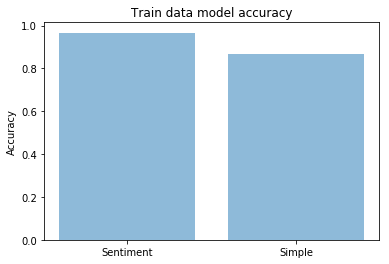

In [68]:
models = ('Sentiment', 'Simple')
y_pos = np.arange(len(models))
train_accuracy = [train_sentiment_accuracy, train_simple_accuracy]
 
plt.bar(y_pos, train_accuracy, align='center', alpha=0.5)
plt.xticks(y_pos, models)
plt.ylabel('Accuracy')
plt.title('Train data model accuracy')
 
plt.show()

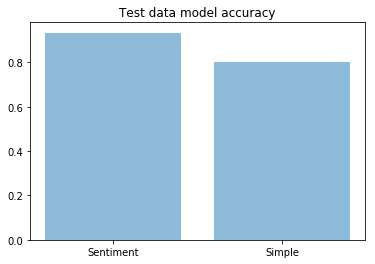

In [69]:
test_accuracy = [test_sentiment_accutacy, test_simple_accuracy]

plt.bar(y_pos, test_accuracy, align='center', alpha=0.5)
plt.xticks(y_pos, models)
plt.title('Test data model accuracy')

plt.show()